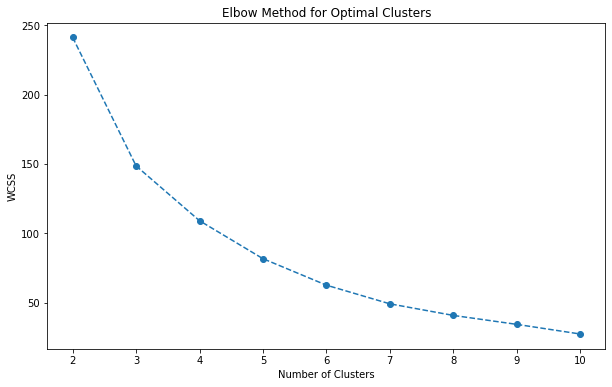

Davies-Bouldin Index: 0.5683835826482855
Clustering Done. file saved


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from datetime import datetime
from fpdf import FPDF

# Loading datasets
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Converting date columns
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Aggregating customer spending data
transactions_df['TotalValue'] = transactions_df['Quantity'] * transactions_df['Price']
customer_spending = transactions_df.groupby('CustomerID')['TotalValue'].sum().reset_index()

# Merging data
customer_data = pd.merge(customers_df, customer_spending, on='CustomerID')
customer_data['CustomerAge'] = (datetime.now() - customer_data['SignupDate']).dt.days // 365

# Selecting features for clustering
features = ['TotalValue', 'CustomerAge']
X = customer_data[features]

# Standardizing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++',random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

# Fitting KMeans 
optimal_clusters = 9
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Compute Davies-Bouldin Index
db_index = davies_bouldin_score(X_scaled, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


# Save clustering report as PDF
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()
pdf.set_font("Arial", size=12)
pdf.cell(200, 10, "Customer Segmentation Report", ln=True, align='C')
pdf.ln(10)
pdf.multi_cell(0, 10, f"Number of Clusters Formed: {optimal_clusters}\n")
pdf.multi_cell(0, 10, f"Davies-Bouldin Index: {db_index}\n")
pdf.multi_cell(0, 10, "Cluster Analysis Summary:\n")
pdf.multi_cell(0, 10, str(customer_data.groupby('Cluster')[features].describe()))
pdf.output("Arvind_Agarwal_Clustering.pdf")

print("Clustering Done. file saved")
